written by: Nutchaya Phumekham, July, 2022

### This is a re-write of the [condor raw data analysis](https://github.com/nutty7fold/cern-crab-data-analysis/blob/main/issue7312/final-brief-analysis-condor-raw-data.ipynb) in order to show example usage of the [crab analysis guide](https://github.com/nutty7fold/cern-crab-data-analysis/blob/main/crab_data_analysis_doc/analysis_guide.md). 

#### Important Note: save file [utils.py](https://github.com/nutty7fold/cern-crab-data-analysis/blob/main/crab_data_analysis_doc/utils.py) in the same directory as your current Jupiter Notebook to use functions from it.

In [57]:
from utils import (
    _to_dict,
    _donut,
    _pie,
    _line_graph,
    _other_fields
)
from datetime import datetime, date, timedelta
from pyspark.sql.functions import (
    col,
    lit,
    when,
    sum as _sum,
    count as _count,
    first,
    date_format,
    from_unixtime
)
import numpy as np
import pandas as pd
from pyspark.sql.types import (
    StructType,
    LongType,
    StringType,
    StructField,
    DoubleType,
    IntegerType,
)

In [3]:
def _get_schema():
    return StructType(
        [
            StructField(
                "data",
                StructType(
                    [
                        StructField("CMSSite", StringType(), nullable=True),
                        StructField("RecordTime", LongType(), nullable=False),
                        StructField("InputData", StringType(), nullable=True),
                        StructField("CMSPrimaryDataTier", StringType(), nullable=True),
                        StructField("Status", StringType(), nullable=True),
                        StructField("OverflowType", StringType(), nullable=True),
                        StructField("WallClockHr", DoubleType(), nullable=True),
                        StructField("CoreHr", DoubleType(), nullable=True),
                        StructField("CpuTimeHr", DoubleType(), nullable=True),
                        StructField("RequestCpus", LongType(), nullable=True),
                        StructField("Type", StringType(), nullable=True),
                        StructField("CRAB_DataBlock", StringType(), nullable=True),
                        StructField("GlobalJobId", StringType(), nullable=False),
                        StructField("ExitCode", LongType(), nullable=True),
                        StructField("Chirp_CRAB3_Job_ExitCode", LongType(), nullable=True),
                        StructField("Chirp_WMCore_cmsRun_ExitCode", LongType(), nullable=True),
                        StructField("JobExitCode", LongType(), nullable=True)
                    ]
                ),
            ),
        ]
    )

In [4]:
_DEFAULT_HDFS_FOLDER = "/project/monitoring/archive/condor/raw/metric"

In [5]:
def get_candidate_files(start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER):
    st_date = start_date - timedelta(days=3)
    ed_date = end_date + timedelta(days=3)
    days = (ed_date - st_date).days
    pre_candidate_files = [
        "{base}/{day}{{,.tmp}}".format(
            base=base, day=(st_date + timedelta(days=i)).strftime("%Y/%m/%d")
        )
        for i in range(0, days)
    ]
    sc = spark.sparkContext
    candidate_files = [
        f"{base}/{(st_date + timedelta(days=i)).strftime('%Y/%m/%d')}"
        for i in range(0, days)
    ]
    FileSystem = sc._gateway.jvm.org.apache.hadoop.fs.FileSystem
    URI = sc._gateway.jvm.java.net.URI
    Path = sc._gateway.jvm.org.apache.hadoop.fs.Path
    fs = FileSystem.get(URI("hdfs:///"), sc._jsc.hadoopConfiguration())
    candidate_files = [url for url in candidate_files if fs.globStatus(Path(url))]
    return candidate_files


In [8]:
schema = _get_schema()
start_date = datetime(2022, 5, 1)
end_date = datetime(2022, 5, 2)

In [10]:
get_candidate_files(start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER)

['/project/monitoring/archive/condor/raw/metric/2022/04/28',
 '/project/monitoring/archive/condor/raw/metric/2022/04/29',
 '/project/monitoring/archive/condor/raw/metric/2022/04/30',
 '/project/monitoring/archive/condor/raw/metric/2022/05/01',
 '/project/monitoring/archive/condor/raw/metric/2022/05/02',
 '/project/monitoring/archive/condor/raw/metric/2022/05/03',
 '/project/monitoring/archive/condor/raw/metric/2022/05/04']

### Get raw data from condor raw

In [11]:
raw_df = (
        spark.read.option("basePath", _DEFAULT_HDFS_FOLDER)
        .json(
            get_candidate_files(start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER),
            schema=schema,
        ).select("data.*")
        .filter(
            f"""Status IN ('Completed', 'Removed', 'Held', 'Error') 
          AND RecordTime >= {start_date.timestamp() * 1000}
          AND RecordTime < {end_date.timestamp() * 1000}
          """
        )
        .drop_duplicates(["GlobalJobId"])
    )

spark.conf.set("spark.sql.session.timeZone", "UTC")

In [12]:
raw_df.printSchema()

root
 |-- CMSSite: string (nullable = true)
 |-- RecordTime: long (nullable = true)
 |-- InputData: string (nullable = true)
 |-- CMSPrimaryDataTier: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- OverflowType: string (nullable = true)
 |-- WallClockHr: double (nullable = true)
 |-- CoreHr: double (nullable = true)
 |-- CpuTimeHr: double (nullable = true)
 |-- RequestCpus: long (nullable = true)
 |-- Type: string (nullable = true)
 |-- CRAB_DataBlock: string (nullable = true)
 |-- GlobalJobId: string (nullable = true)
 |-- ExitCode: long (nullable = true)
 |-- Chirp_CRAB3_Job_ExitCode: long (nullable = true)
 |-- Chirp_WMCore_cmsRun_ExitCode: long (nullable = true)
 |-- JobExitCode: long (nullable = true)



### Task1

#### Sum of "WallClockHr" by "CMSPrimaryDataTier"


In [13]:
df1 = raw_df.groupby([col("CMSPrimaryDataTier")])\
            .agg(_sum("WallClockHr").alias("Sum_WallClockHr"),\
                 _sum("CoreHr").alias("Sum_CoreHr"))\
            .sort("Sum_WallClockHr")

In [14]:
#collect() took 3min while toPandas() took 1 min
df1_dict = _to_dict(df1)

In [18]:
df1_wc = _other_fields(df1_dict['CMSPrimaryDataTier'], df1_dict['Sum_WallClockHr'], 2)
df1_core = _other_fields(df1_dict['CMSPrimaryDataTier'], df1_dict['Sum_CoreHr'], 2)

In [19]:
dictlist1 = [{"index": df1_wc['index'],\
             "values": df1_wc['data_percent'],\
             "title": "Sum WallClockHr Per CMSPrimaryDataTier"},\
            {"index": df1_core['index'],\
             "values": df1_core['data_percent'],\
             "title": "Sum CoreHr Per CMSPrimaryDataTier"}
           ]

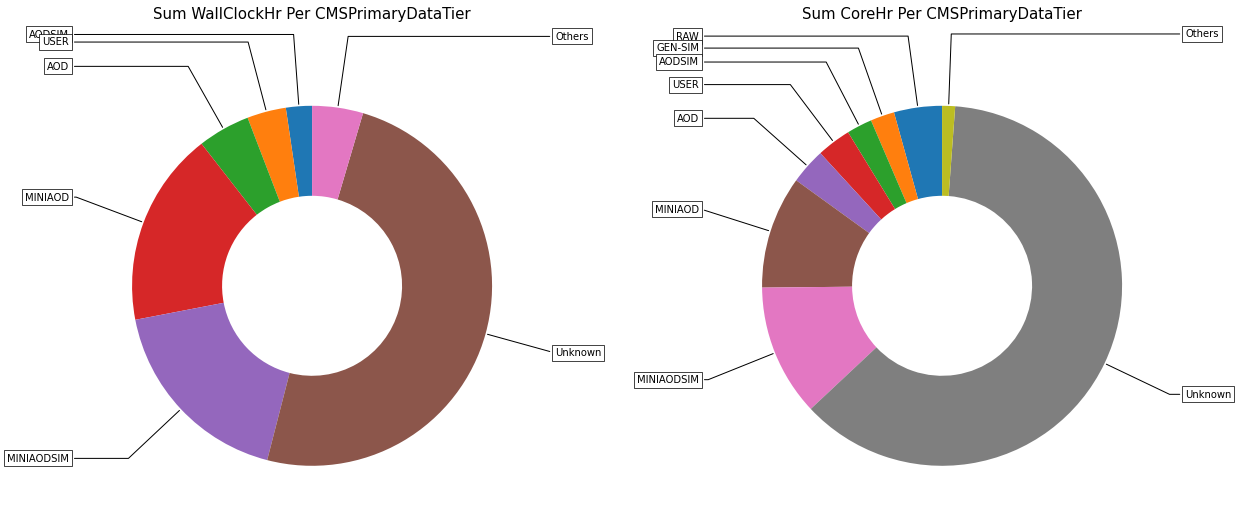

In [20]:
_donut(dictlist1, "wc_core_datatier")

### Task2

#### Sum of "WallClockHr" by "Type" ['production', 'analysis']


In [21]:
df2 = raw_df.filter(col('Type').isin(['production', 'analysis']))\
            .groupby([col('Type')])\
            .agg(_sum("WallClockHr").alias("Sum_WallClockHr"),\
                 _sum("CoreHr").alias("Sum_CoreHr"))

In [22]:
df2_dict = _to_dict(df2)

In [23]:
dictlist2 = [{"index": df2_dict['Type'],\
             "values": df2_dict['Sum_WallClockHr'],\
             "title": "Sum WallClockHr Per Type"},\
            {"index": df2_dict['Type'],\
             "values": df2_dict['Sum_CoreHr'],\
             "title": "Sum CoreHr Per Type"}
           ]

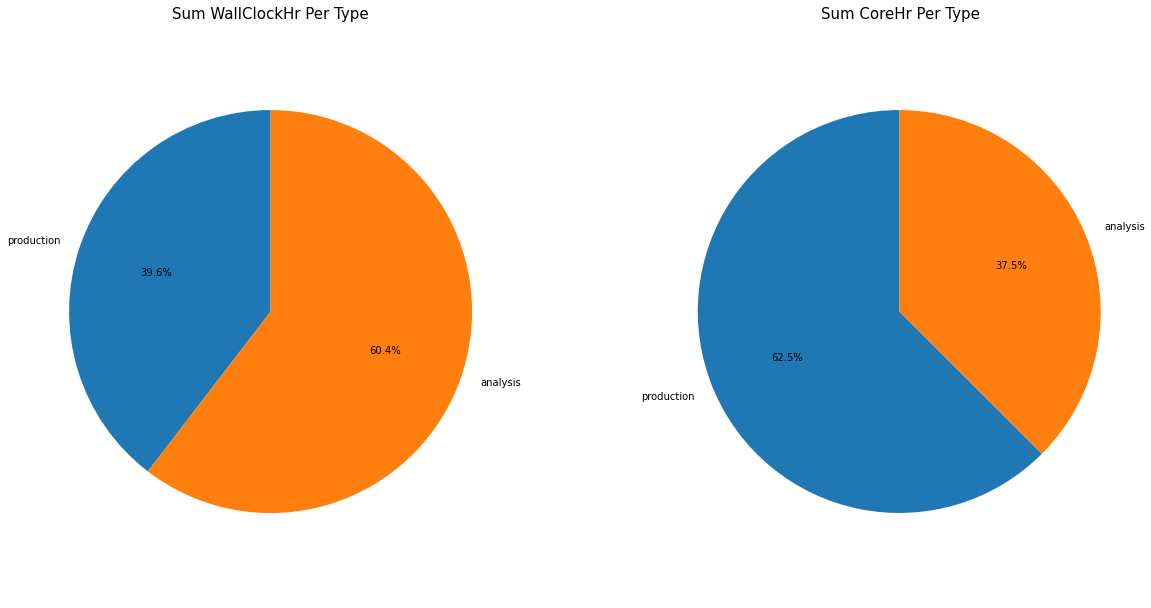

In [24]:
_pie(dictlist2, "wc_core_type")

### Task3

#### Sum of "WallClockHr" filter "Type"['analysis'] by "CRAB_DataBlock" ['MCFakeBlock', Else]

In [26]:
df3 = raw_df.filter(col('Type')=='analysis')\
            .withColumn('isMcprod', when(col('CRAB_DataBlock')=='MCFakeBlock', 'mc').otherwise('notMc'))\
            .groupby([col('isMcprod')])\
            .agg(_sum("WallClockHr").alias("Sum_WallClockHr"),\
                 _sum("CoreHr").alias("Sum_CoreHr"))

In [27]:
df3_dict = _to_dict(df3)

In [28]:
dictlist3 = [{"index": df3_dict['isMcprod'],\
             "values": df3_dict['Sum_WallClockHr'],\
             "title": "Sum WallClockHr Per isMcprod"},\
            {"index": df3_dict['isMcprod'],\
             "values": df3_dict['Sum_CoreHr'],\
             "title": "Sum CoreHr Per isMcprod"}
           ]

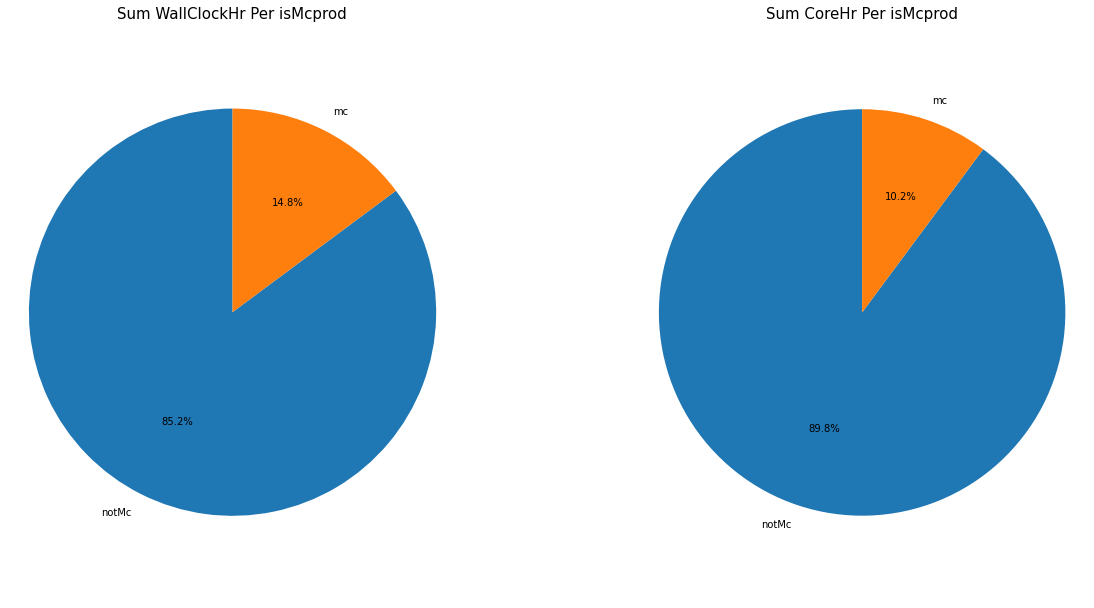

In [29]:
_pie(dictlist3, "wc_core_ismcprod")

### Task4

#### Average CPU Efficiency group by "RecordTime" each hour and "InputData" ['onsite', 'offsite']

In [30]:
raw_df.createOrReplaceTempView("day")
df4 = spark.sql('SELECT     DATE_FORMAT(FROM_UNIXTIME(day.RecordTime/1000), "HH") AS timestamp,\
                            day.InputData AS inputData, \
                            SUM(day.CpuTimeHr) AS sumWallclockHr, \
                            SUM(day.WallClockHr*day.RequestCpus) as sumWallByReqCpus, \
                            SUM(day.CpuTimeHr)/SUM(day.WallClockHr*day.RequestCpus) AS avgCpuEff_Wall, \
                            SUM(day.CoreHr) as sumCoreHr, \
                            SUM(day.CpuTimeHr)/SUM(day.CoreHr) AS avgCpuEff_Core \
                    FROM day \
                    GROUP BY DATE_FORMAT(FROM_UNIXTIME(day.RecordTime/1000), "HH"), inputData\
                    ORDER BY DATE_FORMAT(FROM_UNIXTIME(day.RecordTime/1000), "HH")')

In [34]:
df4_onsite = _to_dict(df4.filter(col('inputData')=='Onsite'))
df4_offsite = _to_dict(df4.filter(col('inputData')=='Offsite'))

In [37]:
figinfo  = {"x_label": "hour in a day","y_label": "avgCpuEff_Core","title": "AVG CPU Efficiency May 1st"}

In [50]:
dictlist4 = [{"y-axis": [float(i) for i in df4_onsite['avgCpuEff_Wall']],\
             "label": "Onsite",\
             "color": "Orange"},\
            {"y-axis": [float(i) for i in df4_offsite['avgCpuEff_Wall']],\
             "label": "Offsite",\
             "color": "Blue"}
           ]

In [55]:
hour = [float(i) for i in df4_onsite['timestamp']]

TypeError: unsupported operand type(s) for +: 'bool' and 'str'

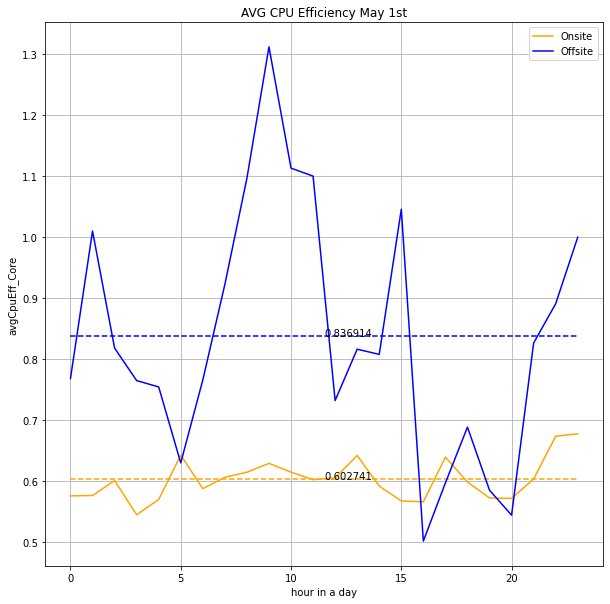

In [58]:
_line_graph(hour, dictlist4, figinfo, True)

### Task5

#### Success rate of the "Type" ['analysis']

In [61]:
df51 = raw_df.select(col('Type'), col('RecordTime'), col('JobExitCode'), col('Chirp_CRAB3_Job_ExitCode'), \
                     col('Chirp_WMCore_cmsRun_ExitCode'), col('ExitCode'))\
            .filter((col("Type")=="analysis")&(col("ExitCode").isNotNull()))\
            .sort('RecordTime')

In [62]:
df52 = df51.select(col('ExitCode'))\
            .groupby(col('ExitCode'))\
            .agg(_count(col('ExitCode')).alias("count_ExitCode"))\
            .sort(col("count_ExitCode").desc())

In [63]:
df52_dict = _to_dict(df52)

In [69]:
df52_other = _other_fields(df52_dict['ExitCode'], df52_dict['count_ExitCode'], 2)

In [70]:
dictlist52 = [{"index": df52_other['index'],\
             "values": df52_other['data_percent'],\
             "title": "count ExitCode"},\
              {"index": df52_other['index'],\
             "values": df52_other['data_percent'],\
             "title": "count ExitCode"}
           ]

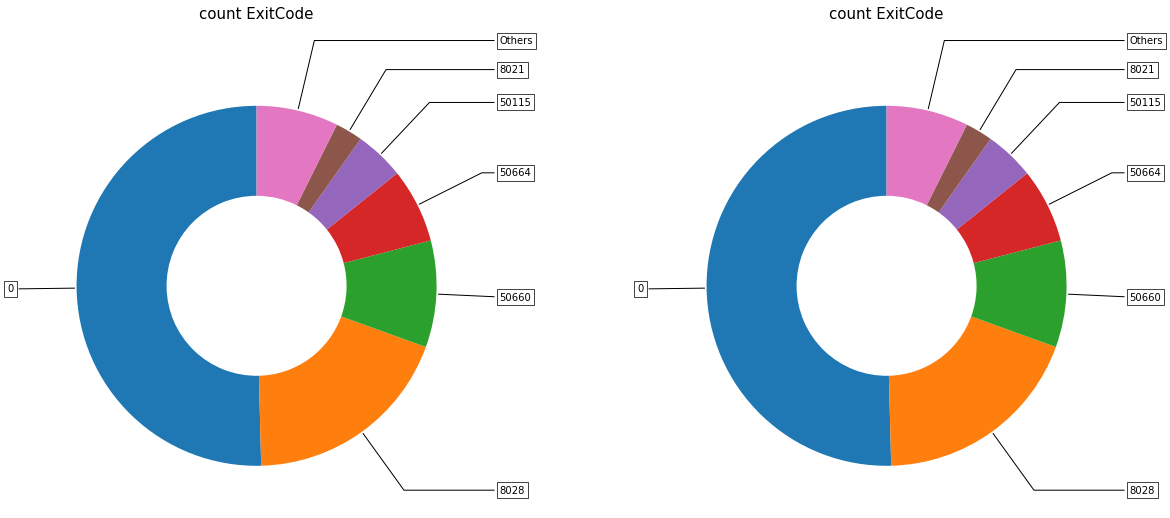

In [71]:
_donut(dictlist52, "exitcode")